# 🚨 Credit Card Fraud Detection with Machine Learning  

This notebook demonstrates how to **train, evaluate, and analyze** a fraud detection model using the **Kaggle Credit Card Fraud dataset**.  

We will cover:  

- 📂 **Data loading & preprocessing**  
- 🤖 **Model training**  
- 📊 **Evaluation** (Confusion Matrix, ROC Curve, Classification Report)  

---



## I) Training and Testing the Model

In [76]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle, class_weight
import numpy as np
import tensorflow as tf
from keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


## Load and Explore the Dataset
We start by loading the dataset and checking its shape, columns, and class balance.


In [77]:
# Load the dataset
df = pd.read_csv("../data/creditcard.csv")

# Optional: Shuffle data (important in imbalanced datasets)
df = shuffle(df, random_state=42)



## Data Preprocessing
We split the dataset into training and testing sets.


In [90]:
# Separate features and target
X = df.drop("Class", axis=1)  # Features
y = df["Class"]               # Target (0 = legit, 1 = fraud)

# Scale the features (Important for NN convergence)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test (Stratify to keep fraud ratio same)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Data prepared. Training samples:", len(X_train), "Test samples:", len(X_test))


Data prepared. Training samples: 227845 Test samples: 56962


## For cleaner code
We use these modules to remove extra logs in console and to hide the warnings generated.

In [79]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # Hide most TF logs

# Suppress protobuf runtime version warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='google.protobuf')


## Calculating the class weights

In [80]:
# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: np.float64(0.5008661206149896), 1: np.float64(289.14340101522845)}


## Model Architecture
We define a simple neural network for fraud detection.


In [110]:
# Define the neural network
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_auc', patience=5, mode='max' , restore_best_weights=True)

## Training
We train the model with the training dataset and validate on the test set.


In [111]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=2048,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=2,
    class_weight = class_weights
)

Epoch 1/50
90/90 - 1s - 10ms/step - accuracy: 0.6777 - auc: 0.7617 - loss: 0.6242 - val_accuracy: 0.9292 - val_auc: 0.9255 - val_loss: 0.4617
Epoch 2/50
90/90 - 0s - 1ms/step - accuracy: 0.8938 - auc: 0.8692 - loss: 0.4197 - val_accuracy: 0.9819 - val_auc: 0.9518 - val_loss: 0.3084
Epoch 3/50
90/90 - 0s - 1ms/step - accuracy: 0.9472 - auc: 0.8943 - loss: 0.3582 - val_accuracy: 0.9841 - val_auc: 0.9587 - val_loss: 0.2229
Epoch 4/50
90/90 - 0s - 1ms/step - accuracy: 0.9585 - auc: 0.9400 - loss: 0.2758 - val_accuracy: 0.9846 - val_auc: 0.9640 - val_loss: 0.1696
Epoch 5/50
90/90 - 0s - 1ms/step - accuracy: 0.9638 - auc: 0.9517 - loss: 0.2493 - val_accuracy: 0.9822 - val_auc: 0.9666 - val_loss: 0.1371
Epoch 6/50
90/90 - 0s - 1ms/step - accuracy: 0.9693 - auc: 0.9669 - loss: 0.2097 - val_accuracy: 0.9814 - val_auc: 0.9675 - val_loss: 0.1169
Epoch 7/50
90/90 - 0s - 1ms/step - accuracy: 0.9724 - auc: 0.9767 - loss: 0.1892 - val_accuracy: 0.9827 - val_auc: 0.9683 - val_loss: 0.0921
Epoch 8/50
9

## This helps in saving the model for evaluation
This saved model will not be used below in this notebook, but while working in Visual Studio Code it is sometimes useful to save the trained model as it may be used in different codes. 

In [112]:
model.save("../models/fraud_model.keras")

## II) Evaluating the performance 

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc


We evaluate the performance of our trained model by calculating the evaluation metrics: **Test Accuracy**, **Test AUC (Area Under the Curve)**, and **Test Loss**, reported up to four decimal places.


In [114]:
# Evaluate the model
test_loss, test_accuracy, test_auc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nModel Evaluation:\n-----------------")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


Model Evaluation:
-----------------
Test Accuracy: 0.9783
Test AUC: 0.9578
Test Loss: 0.0575


# Plotting the Confusion Matrix
It shows the number of correct and incorrect predictions, broken down by each class.

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 0s 183us/step


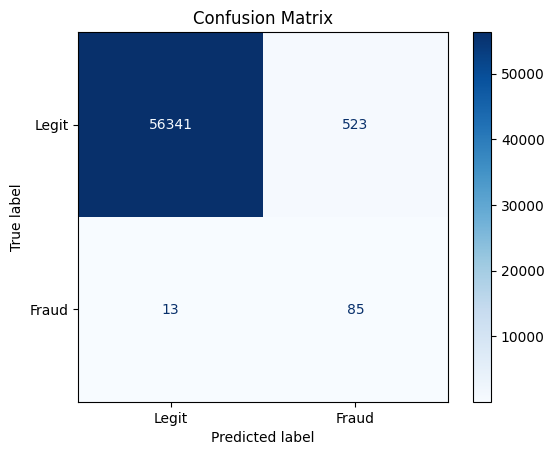

In [115]:
# Predictions
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs >= 0.7).astype("int")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legit", "Fraud"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


# Classification Report
It is the summary of precision, recall, F1-score, and support for each class.

In [116]:
# Classification report
print("\nClassification Report:\n-----------------------")
print(classification_report(y_test, y_pred, target_names=["Legit", "Fraud"],digits=4))



Classification Report:
-----------------------
              precision    recall  f1-score   support

       Legit     0.9998    0.9908    0.9953     56864
       Fraud     0.1398    0.8673    0.2408        98

    accuracy                         0.9906     56962
   macro avg     0.5698    0.9291    0.6180     56962
weighted avg     0.9983    0.9906    0.9940     56962



# ROC Curve
It is a metric that measures the model’s ability to distinguish between classes across all thresholds.

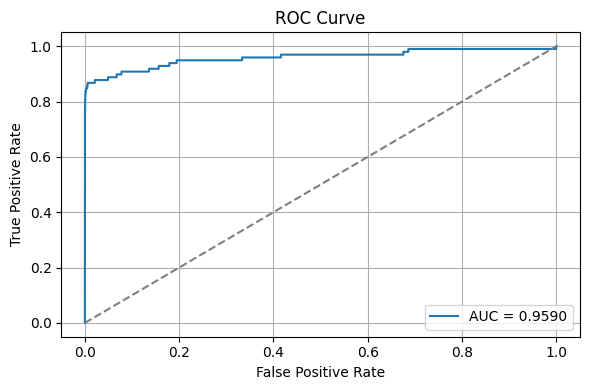

In [117]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()